## ResNet18 + AbMIL

In this notebook we uesd ResNet18 as a feature extractor and AbMIL model to predict the classes of the patients.

In [1]:
import warnings
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### 1- Resnet18 backbone to generate feature vectors

In [2]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)

backbone = torch.nn.Sequential(*list(resnet.children())[:-1])
for param in backbone.parameters():
    param.requires_grad = False
model1 = torch.nn.Sequential(backbone, torch.nn.Flatten()).to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
    transforms.Lambda(lambda x: x.unsqueeze(0)) 
])

### 2 - Data Laoding:

In [3]:
from Patient import Patient, PatientDataset
from utils import preprocess_metadata
from AbMIL import PatientAMIL

In [4]:
train_set_meta, test_set_meta = preprocess_metadata()
train_dataset = []
test_dataset = []

# Load train patients
for patient_id in train_set_meta.index:
    patient_info = train_set_meta.loc[patient_id]
    images_path = os.path.join('../dataset/trainset', patient_id)
    label = patient_info['LABEL']
    patient = Patient(ID=patient_id,
                      age=patient_info['AGE'],
                      gender=patient_info['GENDER'],
                      lymph_count=patient_info['LYMPH_COUNT'],
                      images_path=images_path,
                      label=label,
                      model=model1)  
    train_dataset.append(patient)

# Load test patients
for patient_id in test_set_meta.index:
    patient_info = test_set_meta.loc[patient_id]
    images_path = os.path.join('../dataset/testset', patient_id)
    patient = Patient(ID=patient_id,
                      age=patient_info['AGE'],
                      gender=patient_info['GENDER'],
                      lymph_count=patient_info['LYMPH_COUNT'],
                      images_path=images_path,
                      model=model1)  
    test_dataset.append(patient)

# Extract features or load features from CSV and save features to CSV
for dataset in [train_dataset, test_dataset]:
    for patient in dataset:
        patient.extract_features()

# Print the number of train/test patients
print(f"Number of train patients: {len(train_dataset)}")
print(f"Number of test patients: {len(test_dataset)}")

Number of train patients: 163
Number of test patients: 42


In [5]:
#example
sample = train_dataset[0]
print(sample)
print("Number of features", len(sample.features), "of size",len(sample.features[0]))
print("last two feautures are encoded age and lymph count")


Patient ID: P26, Age: 91.0, Gender: 0.0, Lymphocyte Count: 11.2, Label: 1.0, Number of Images: 100
Number of features 102 of size 512
last two feautures are encoded age and lymph count


- Each patient has number of images + 2 features (corresponding to age / lymph count) of size 512 (dimension of the feature vector of resnet18)
- Patients are supposed to be bags of instances, where each instance corresponds to a feature. 
- We used 40% of parients for validation

In [7]:
train_data = []
for patient in train_dataset:
    train_data.append((patient.features, patient.label))

test_data = []
for patient in test_dataset:
    test_data.append((patient.features, patient.label))


train_data, val_data = train_test_split(train_data, test_size=0.4, random_state=42,stratify=train_set_meta['SUBGROUP'])
print(f"Number of train patients: {len(train_data)}")
print(f"Number of validation patients: {len(val_data)}")
print(f"Number of test patients: {len(test_data)}")

batch_size = 16

train_set = PatientDataset(train_data)
val_set = PatientDataset(val_data)

Number of train patients: 97
Number of validation patients: 66
Number of test patients: 42


### Training the AbMIL Model

Balanced Accuracy on the validation set: 69.70%
Best model saved.
Epoch 5, Train Loss: 0.5607313816387629
Epoch 5, Val Loss: 0.5339105467904698
Balanced Accuracy on the validation set: 71.21%
Best model saved.
Epoch 10, Train Loss: 0.4362104829669613
Epoch 10, Val Loss: 0.42460769025439565
Balanced Accuracy on the validation set: 75.76%
Best model saved.
Balanced Accuracy on the validation set: 84.85%
Best model saved.
Epoch 15, Train Loss: 0.32683221027783127
Epoch 15, Val Loss: 0.35135309527995007
Epoch 20, Train Loss: 0.2816705277499253
Epoch 20, Val Loss: 0.3413701911675603
Epoch 25, Train Loss: 0.2605800709428239
Epoch 25, Val Loss: 0.3450511351124574
Epoch 30, Train Loss: 0.241538320936052
Epoch 30, Val Loss: 0.3543922167933267
Epoch 35, Train Loss: 0.21922612874704167
Epoch 35, Val Loss: 0.37854570535354826
Epoch 40, Train Loss: 0.1973701130679316
Epoch 40, Val Loss: 0.42544821059856064
Epoch 45, Train Loss: 0.1812207579797833
Epoch 45, Val Loss: 0.48539603090453565
Epoch 50, Tr

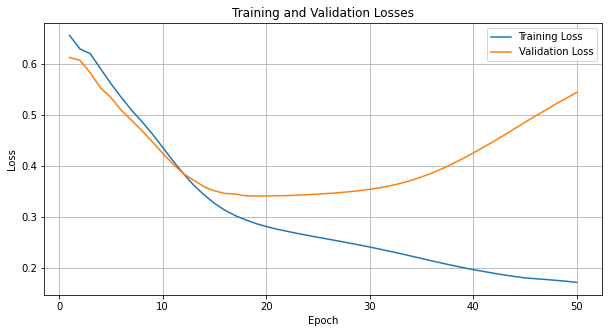

In [12]:
input_dim = 512  
hidden_dim = 256 
n_classes = 2  
model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)

# Training loop
num_epochs = 50
best_balanced_accuracy = 0.0
best_model_path = 'best_model_resnet18_Abmil.pth'  # Path to save the best model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_features, batch_labels in train_set:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs, _, _ = model(batch_features)
        loss = criterion(outputs, batch_labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_set))
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_set)}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_set:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels.long())
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += batch_labels.size(0)
            correct_val += (predicted_val == batch_labels).sum().item()

    val_losses.append(val_loss / len(val_set))
    val_accuracy = correct_val / total_val
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}, Val Loss: {val_losses[-1]}")
    if val_accuracy > best_balanced_accuracy:
        best_balanced_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Balanced Accuracy on the validation set: {100 * val_accuracy:.2f}%")
        print("Best model saved.")

    lr_scheduler.step(train_losses[-1])  # Pass the last training loss for learning rate scheduler

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

- We trained the model to predict the labels of the subjects and we monitored the training using the validation balanced accuracy. We can see in the figure that the model overfits at the end. However, we saved the model from the epoch 13 for which we had the minimal validation loss to be used in for the test set and 84.85% of balanced accuracy.

In [10]:
best_model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

# Generate predictions for the test set
predictions = []
with torch.no_grad():
    predictions = {}
    for patient in test_dataset:
        batch_features = torch.from_numpy(np.array(patient.features)).to(device)
        outputs, _, _ = best_model(batch_features)
        _, predicted = torch.max(outputs, 1)
        predictions[patient.ID] = predicted.item()
print(predictions)

with open('predictions.csv', 'w') as f:
    f.write("Id,Predicted\n")
    for patient_id, prediction in predictions.items():
        f.write(f"{patient_id},{prediction}\n")


{'P71': 1, 'P16': 1, 'P114': 0, 'P170': 0, 'P98': 1, 'P69': 1, 'P92': 1, 'P132': 1, 'P81': 1, 'P73': 0, 'P143': 1, 'P175': 1, 'P56': 1, 'P139': 1, 'P152': 1, 'P203': 1, 'P75': 1, 'P9': 1, 'P24': 0, 'P4': 1, 'P32': 1, 'P120': 1, 'P138': 1, 'P172': 1, 'P57': 0, 'P195': 1, 'P68': 0, 'P133': 1, 'P14': 1, 'P119': 1, 'P7': 0, 'P49': 1, 'P93': 1, 'P178': 1, 'P58': 1, 'P108': 1, 'P197': 1, 'P196': 1, 'P86': 0, 'P18': 0, 'P188': 0, 'P148': 0}
